In [1]:
# Include Required Libraries
import pandas as pd
import numpy  as np
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import desc
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler #feature transformer that merges multiple columns into a vector column
from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.evaluation import BinaryClassificationEvaluator #evaluate accuracy 
#from pyspark.context import SparkContext
#from pyspark.sql.session import SparkSession
sc= SparkContext(appName="my_app1", master= "local[1]") 
sqlContext = SQLContext(sc) 
from graphframes import *
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
# Load the file in SQL Context
df = sqlContext.read.load("C:\\...\\chicago-divvy-bicycle-sharing-data\\data.csv",format='com.databricks.spark.csv',header='true',inferSchema='true')

In [3]:
# Creating view 
df.createOrReplaceTempView("divvy")

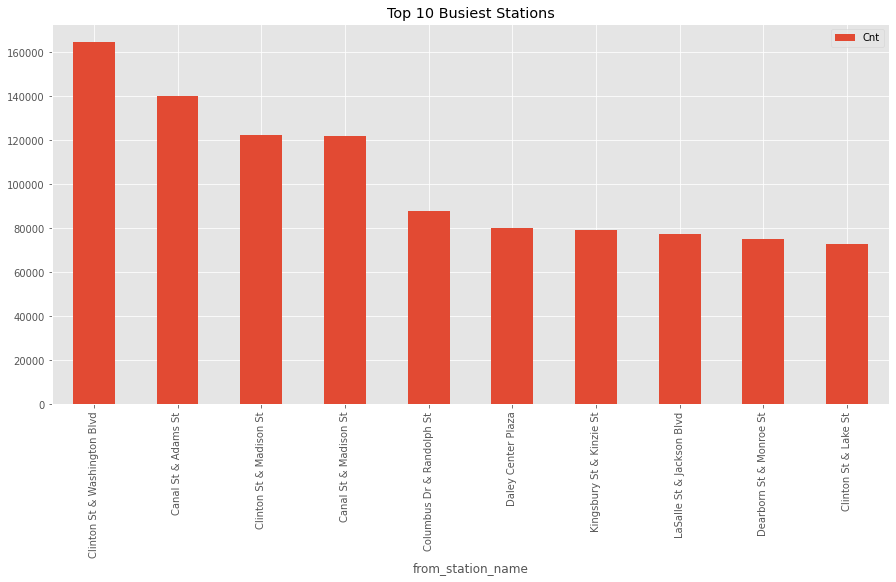

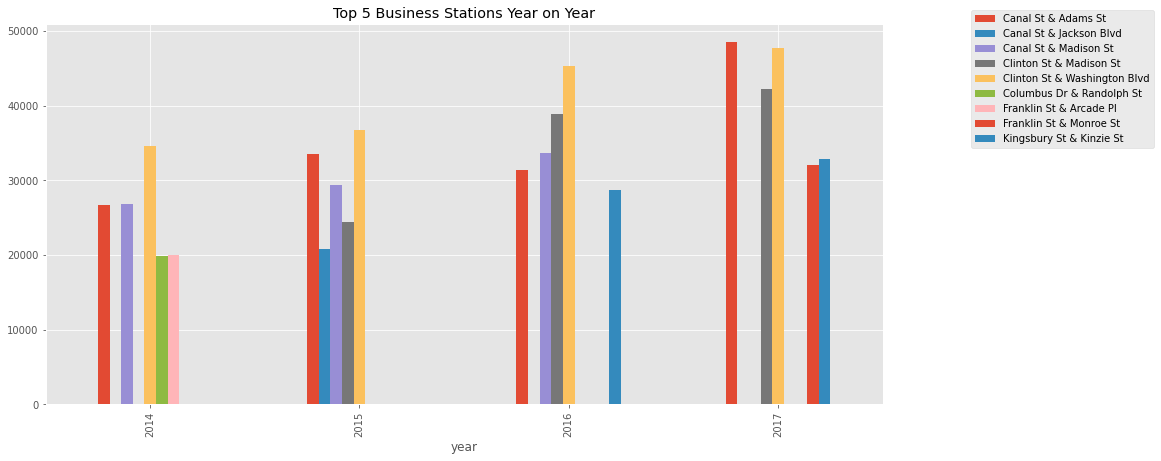

In [4]:
'a: Query for count of trips based on station name and sort'
top_stat = sqlContext.sql("SELECT from_station_name, COUNT(*) as Cnt FROM divvy GROUP BY from_station_name ORDER BY Cnt DESC")

'b: Query for count of trips based on year,station name and sort'
top_stat_year = sqlContext.sql("SELECT year,from_station_name, COUNT(*) as Cnt FROM divvy GROUP BY year,from_station_name ORDER BY year,Cnt DESC")

#Create Pandas Dataframe
x1=top_stat.toPandas()
x2=top_stat_year.toPandas()
x3=x2.groupby('year').head(5)

#Plot top 10 busiest station
x1.head(10).plot(kind="bar", x="from_station_name", y="Cnt", title="Top 10 Busiest Stations", figsize=(15,7))
plt.legend()
plt.show()

# Plot top 5 busiest station year on year
x3.pivot("year", "from_station_name", "Cnt").plot(kind='bar', title="Top 5 Business Stations Year on Year",figsize=(15,7))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

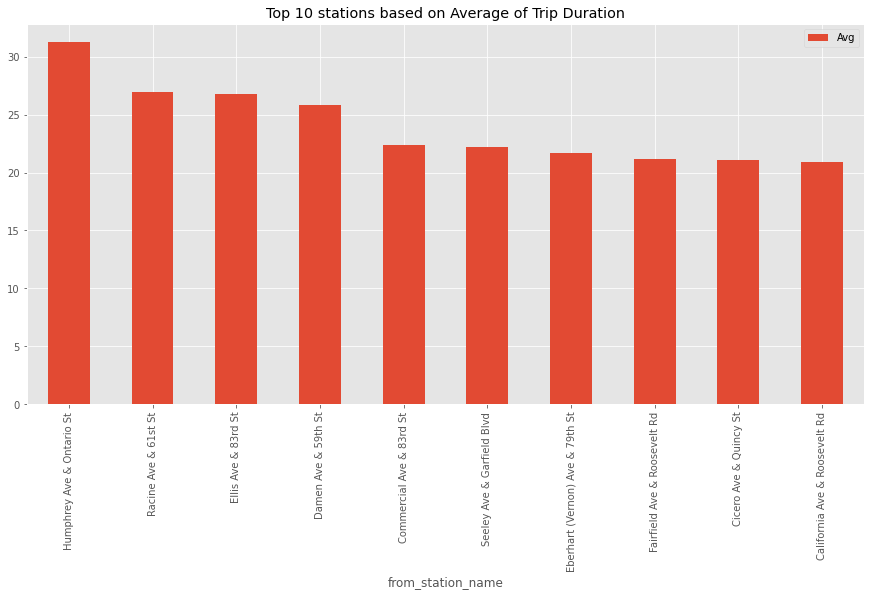

In [5]:
'c: Top 10 stations based on average of trip duration'

top_avg_stat = sqlContext.sql("SELECT from_station_name, AVG(tripduration) as Avg FROM divvy GROUP BY from_station_name ORDER BY Avg DESC")

# Visualization
top_avg=top_avg_stat.toPandas()
top_avg.head(10).plot(kind="bar", x="from_station_name", y="Avg", 
                      title= "Top 10 stations based on Average of Trip Duration", figsize=(15,7))
plt.legend()
plt.show()

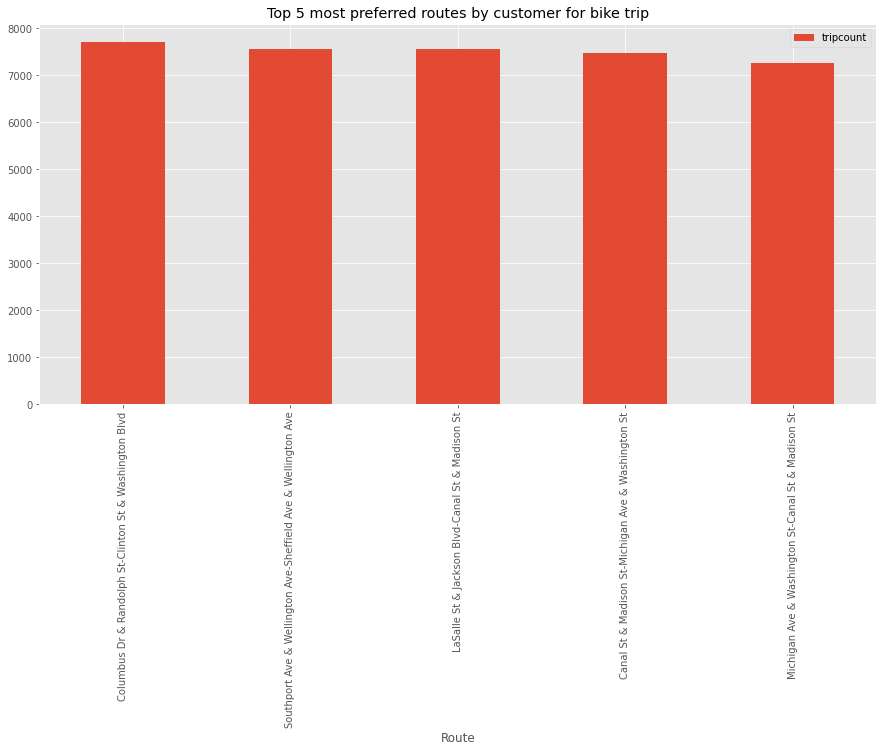

In [6]:
'd: Top 5 most preferred routes by customer for bike trip'
Most_pref= sqlContext.sql("SELECT from_station_name, to_station_name, COUNT(*) as tripcount FROM divvy GROUP BY from_station_name, to_station_name ORDER BY tripcount DESC")
Most_pref_df = Most_pref.toPandas()
Most_pref_df['Route'] = Most_pref_df['from_station_name']+'-'+Most_pref_df['to_station_name']

# Visualization
Most_pref_df.head(5).plot(kind="bar", x="Route", y="tripcount", 
                          title= "Top 5 most preferred routes by customer for bike trip", figsize=(15,7))
plt.legend()
plt.show()

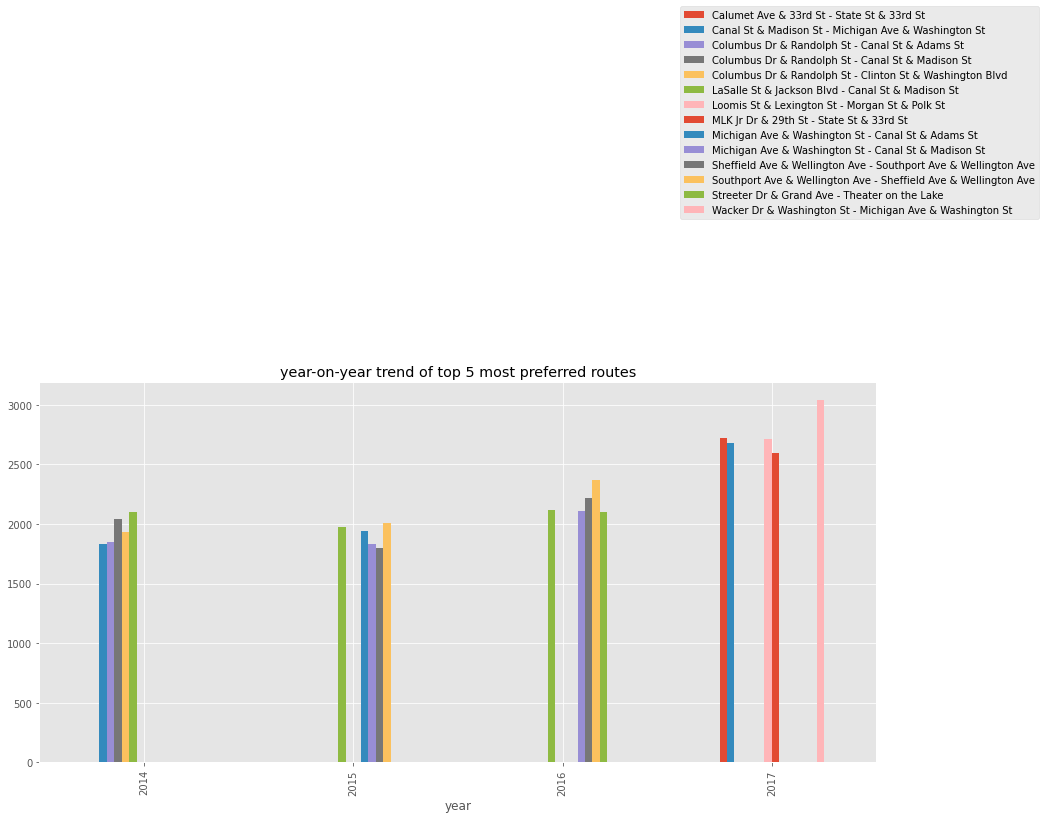

In [7]:
'e: Visualization of year-on-year trend of top 5 most preferred routes-'

vis_sol6_0= sqlContext.sql("SELECT year, CONCAT(from_station_name, ' - ',to_station_name) as route, COUNT(*) as tripcounts FROM divvy GROUP BY year, from_station_name, to_station_name ORDER BY year, tripcounts DESC")

## Converting sql dataframe to pandas dataframe using Spark Core

preferred_route= [item[1] for item in vis_sol6_0.collect()]
year = [item[0] for item in vis_sol6_0.collect()]
tripcounts = [item[2] for item in vis_sol6_0.collect()]

most_preferred_routes = {"year":year, "preferredroute" : preferred_route, "tripcounts" : tripcounts}
mpr = pd.DataFrame(most_preferred_routes)
#Group by year - Extract 5 top preferrent routes and their tripcounts for each year.
mpr1=mpr.groupby('year').head(5)
#display(mpr1)

##Using pivot function for visualizing year-on-year trend of top 5 most preferred routes-

mpr1.pivot("year", "preferredroute", "tripcounts").plot(kind='bar', 
                                                        title="year-on-year trend of top 5 most preferred routes", 
                                                        figsize=(15,7))
plt.legend(bbox_to_anchor=(1.2, 2))
plt.show()
# Year-on-Year the trip counts are increasing on most preferred route.



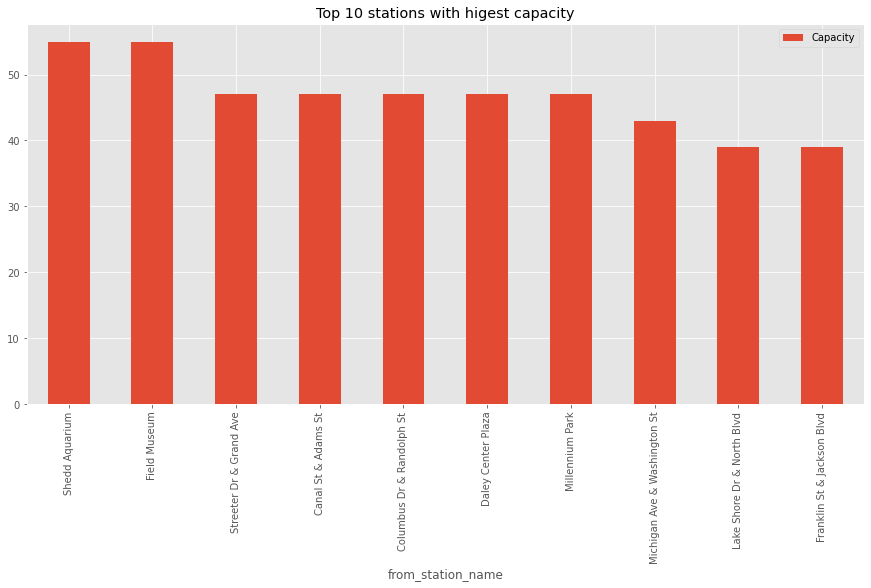

In [8]:
'f: Top 10 stations with higest capacity'
top_cap_stat = sqlContext.sql("SELECT from_station_name, MAX(dpcapacity_start) as Capacity FROM divvy GROUP BY from_station_name ORDER BY Capacity DESC")

# Visualization
top_cap=top_cap_stat.toPandas()
top_cap.head(10).plot(kind="bar", x="from_station_name", y="Capacity", 
                      title= "Top 10 stations with higest capacity",
                      figsize=(15,7))
plt.legend()
plt.show()

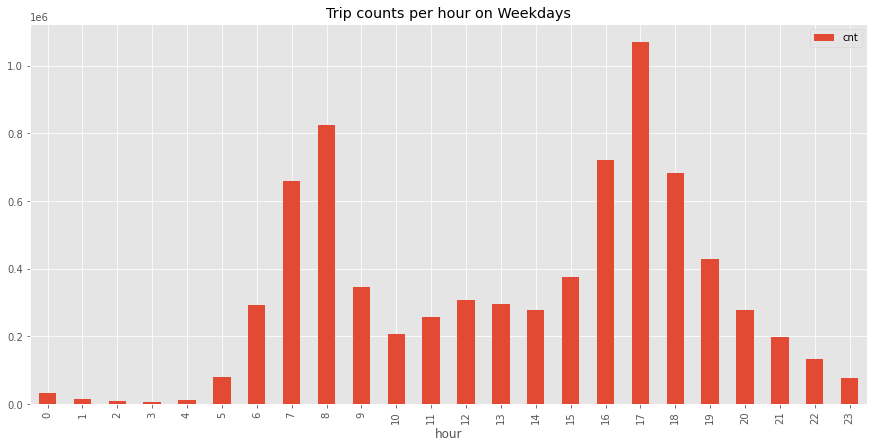

In [9]:
'g: Trip counts per hour on Weekdays'
weekday_hours_stats = sqlContext.sql("SELECT hour, COUNT(trip_id) as cnt FROM divvy WHERE day<>5 AND day<>6 AND day<>7 GROUP BY hour ORDER BY hour ")
# Visualization
weekday_count_hours=weekday_hours_stats.toPandas()
weekday_count_hours.plot(kind="bar", x="hour", y="cnt", 
                         title="Trip counts per hour on Weekdays", 
                         figsize=(15,7))
plt.legend()
plt.show()

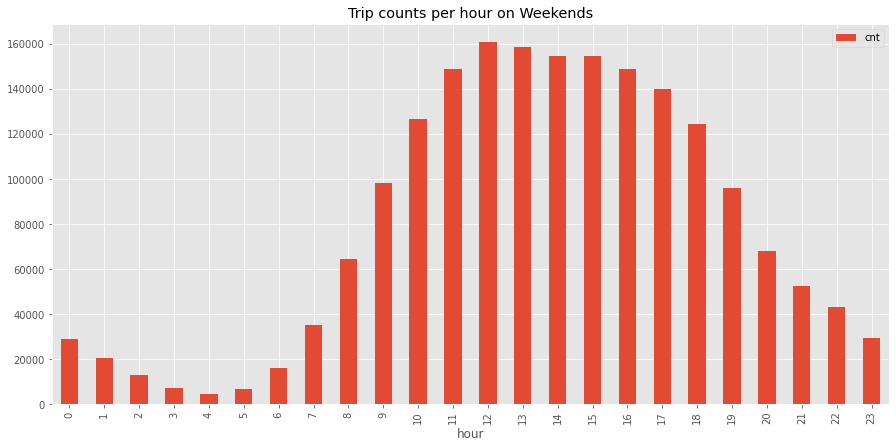

In [10]:
'h: Trip counts per hour on Weekends'
weekend_hours_stats = sqlContext.sql("SELECT hour, COUNT(trip_id) as cnt FROM divvy WHERE day==5 OR day==6 OR day==7 GROUP BY hour ORDER BY hour ")
# Visualization
weekend_count_hours=weekend_hours_stats.toPandas()
weekend_count_hours.plot(kind="bar", x="hour", y="cnt", 
                         title="Trip counts per hour on Weekends", figsize=(15,7))
plt.legend()
plt.show()

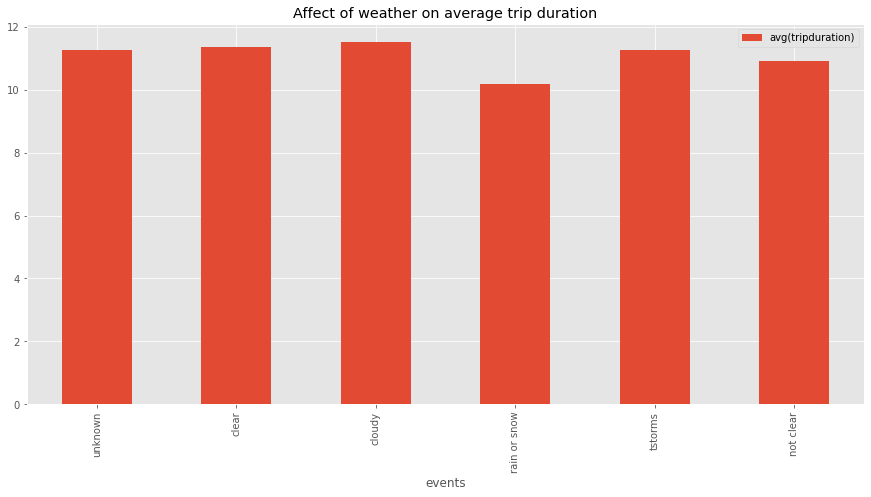

In [11]:
'i: Affect of weather on average trip duration'
trip_delay = sqlContext.sql("SELECT events,avg(tripduration) FROM divvy group by events ")
x_delay=trip_delay.toPandas()
# Visualization
x_delay.plot(x='events', y='avg(tripduration)',kind="bar", 
             title= "Affect of weather on average trip duration",
             figsize=(15,7))
plt.show()

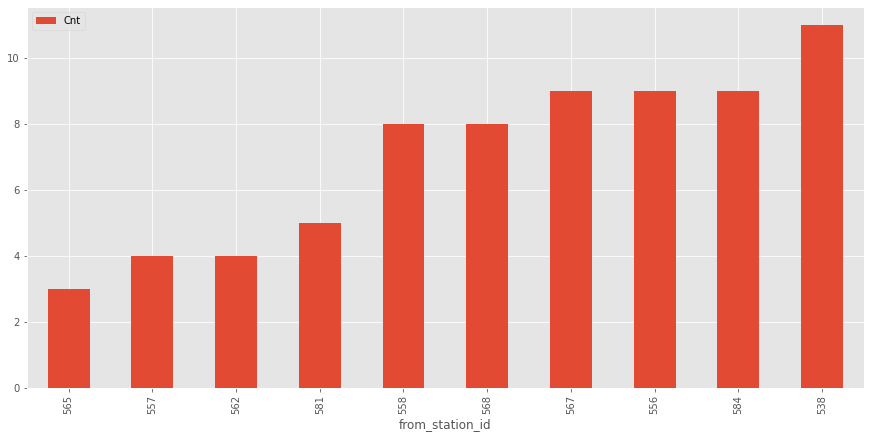

In [12]:
'j: To 10 least trip generating stations in 2017'

bot_stat_year = sqlContext.sql("SELECT year,from_station_id, COUNT(*) as Cnt, AVG(dpcapacity_start)  FROM divvy GROUP BY year,from_station_id ORDER BY year,Cnt")
x4=bot_stat_year.toPandas()
bot_stat=x4[x4['year']==2017]
bot_stat.head(10).plot(kind="bar", x="from_station_id", y="Cnt", figsize=(15,7))
#plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [13]:
'k: Five Least Preffered route Analysis:'

lp_route= sqlContext.sql("SELECT from_station_name, to_station_name, COUNT(*) as tripcount FROM divvy WHERE year = 2017 GROUP BY from_station_name, to_station_name ORDER BY tripcount")
lp_route.show(5)

+--------------------+--------------------+---------+
|   from_station_name|     to_station_name|tripcount|
+--------------------+--------------------+---------+
|Racine Ave (May S...|Emerald Ave & 31s...|        1|
|California Ave & ...|Clark St & Chicag...|        1|
|Central Park Ave ...|Clark St & Montro...|        1|
|Halsted St & 63rd St|MLK Jr Dr & 56th ...|        1|
|Central Park Blvd...|Kedzie Ave & Harr...|        1|
+--------------------+--------------------+---------+
only showing top 5 rows

